In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using CSV: /kaggle/input/attacker-only/attackers_only.csv
ℹ️  Optional column 'shots' missing → filling with default: 0
ℹ️  Optional column 'dribbles' missing → filling with default: 0
ℹ️  Optional column 'key_passes' missing → filling with default: 0
ℹ️  Optional column 'xg' missing → filling with default: 0.0
ℹ️  Optional column 'shot_accuracy' missing → filling with default: 0.0
ℹ️  Optional column 'big_chances_created' missing → filling with default: 0
ℹ️  Optional column 'aerial_duels_won' missing → filling with default: 0
ℹ️  Optional column 'contract_remaining' missing → filling with default: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 1557, number of used features: 30
[LightGBM] [Info] Start training from score 14.326329
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1091
[LightGBM] [Info] Number of data points in the train set: 1245, number of used features: 30
[LightGBM] [Info] Start training from score 14.308127
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set

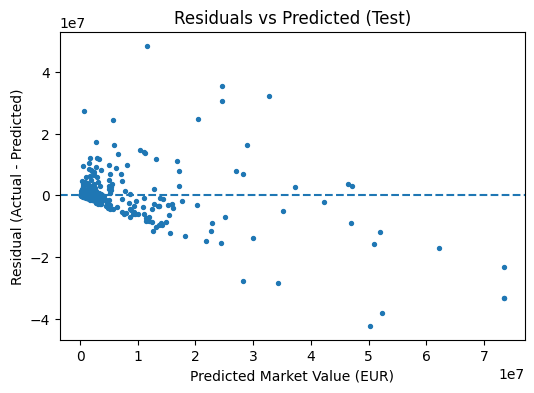

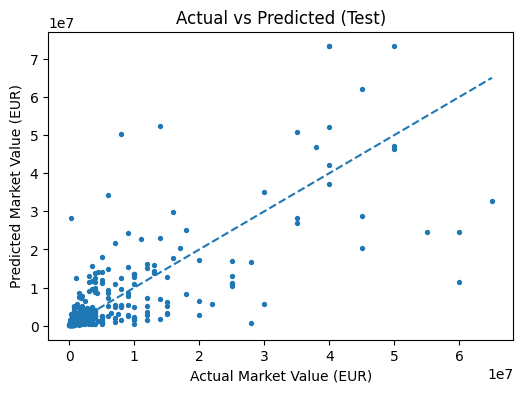


Largest absolute errors (Top 15):
 actual_eur     pred_eur    abs_error    pct_error
 60000000.0 1.154649e+07 4.845351e+07    80.755849
  8000000.0 5.028102e+07 4.228102e+07   528.512780
 14000000.0 5.229390e+07 3.829390e+07   273.527888
 60000000.0 2.466081e+07 3.533919e+07    58.898646
 40000000.0 7.339528e+07 3.339528e+07    83.488210
 40000000.0 7.339528e+07 3.339528e+07    83.488210
 65000000.0 3.282533e+07 3.217467e+07    49.499492
 55000000.0 2.457126e+07 3.042874e+07    55.324979
  6000000.0 3.431825e+07 2.831825e+07   471.970776
   275000.0 2.820286e+07 2.792786e+07 10155.584217
 28000000.0 7.248310e+05 2.727517e+07    97.411318
 45000000.0 2.045171e+07 2.454829e+07    54.551745
 30000000.0 5.660902e+06 2.433910e+07    81.130327
 50000000.0 7.339528e+07 2.339528e+07    46.790568
 20000000.0 2.789347e+06 1.721065e+07    86.053265

Saved model artifacts to: /kaggle/working


In [2]:
# =========================================
# Attacker Market Value Prediction (Kaggle)
# =========================================

# --- Optional installs (uncomment only if needed) ---
# !pip -q install lightgbm xgboost catboost

import os
import glob
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
# from sklearn.linear_model import LinearRegression  # (kept if you prefer linear meta-model)

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import joblib

# -------------------------
# 1) Load data
# -------------------------
DATA_DIR = "/kaggle/input/attacker-only"
csv_candidates = glob.glob(os.path.join(DATA_DIR, "*.csv"))
assert len(csv_candidates) >= 1, f"No CSV found in {DATA_DIR}"
CSV_PATH = csv_candidates[0]
print("Using CSV:", CSV_PATH)

df = pd.read_csv(CSV_PATH)

# -------------------------
# 2) Basic sanitization
# -------------------------
# Normalize column names: lowercase + underscores
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Helper: try to find a column by synonyms / contains
def find_col(candidates, dfcols):
    dfset = set(dfcols)
    for cand in candidates:
        if cand in dfset:
            return cand
    # fuzzy contains
    for col in dfcols:
        for cand in candidates:
            if cand in col:
                return col
    return None

# Build a tolerant column map
col_map = {}
col_map["age"]              = find_col(["age"], df.columns) or "age"
col_map["height"]           = find_col(["height", "height_cm", "height_(cm)", "player_height"], df.columns) or "height"
col_map["preferred_foot"]   = find_col(["preferred_foot", "foot"], df.columns) or "preferred_foot"
col_map["goals"]            = find_col(["goals", "total_goals"], df.columns) or "goals"
col_map["assists"]          = find_col(["assists", "total_assists"], df.columns) or "assists"
col_map["minutes_played"]   = find_col(["minutes_played", "mins_played", "minutes"], df.columns) or "minutes_played"
col_map["yellow_cards"]     = find_col(["yellow_cards", "yellows"], df.columns) or "yellow_cards"
col_map["red_cards"]        = find_col(["red_cards", "reds"], df.columns) or "red_cards"
col_map["shots"]            = find_col(["shots", "total_shots"], df.columns) or "shots"
col_map["dribbles"]         = find_col(["dribbles", "dribbles_total"], df.columns) or "dribbles"
col_map["key_passes"]       = find_col(["key_passes", "keypasses"], df.columns) or "key_passes"
col_map["xg"]               = find_col(["xg", "expected_goals"], df.columns) or "xg"
col_map["shot_accuracy"]    = find_col(["shot_accuracy", "shots_on_target_pct", "sot%"], df.columns) or "shot_accuracy"
col_map["big_chances_created"] = find_col(["big_chances_created", "big_chances"], df.columns) or "big_chances_created"
col_map["aerial_duels_won"] = find_col(["aerial_duels_won", "aerials_won"], df.columns) or "aerial_duels_won"
col_map["league"]           = find_col(["league", "competition"], df.columns) or "league"
col_map["team"]             = find_col(["team", "club"], df.columns) or "team"
col_map["contract_remaining"]= find_col(["contract_remaining", "contract_left", "contract_months"], df.columns) or "contract_remaining"
col_map["market_value"]     = find_col(["market_value", "value", "transfer_value"], df.columns) or "market_value"

# -------------------------
# 2a) Safe column validation & auto-fill defaults
# -------------------------
required = ["age", "height", "preferred_foot", "goals", "assists", "minutes_played", "market_value"]
default_values = {
    "age": 25,
    "height": 180.0,
    "preferred_foot": "Right",
    "goals": 0,
    "assists": 0,
    "minutes_played": 0,
    "market_value": np.nan,
}
for key in required:
    colname = col_map[key]
    if colname not in df.columns:
        print(f"⚠️  Missing column '{colname}' → creating with default: {default_values[key]}")
        df[colname] = default_values[key]

# Optional columns: create if missing
optional_cols_defaults = {
    col_map["yellow_cards"]: 0,
    col_map["red_cards"]: 0,
    col_map["shots"]: 0,
    col_map["dribbles"]: 0,
    col_map["key_passes"]: 0,
    col_map["xg"]: 0.0,
    col_map["shot_accuracy"]: 0.0,
    col_map["big_chances_created"]: 0,
    col_map["aerial_duels_won"]: 0,
    col_map["league"]: "other",
    col_map["team"]: "unknown",
    col_map["contract_remaining"]: 0.0,
}
for colname, default_val in optional_cols_defaults.items():
    if colname not in df.columns:
        print(f"ℹ️  Optional column '{colname}' missing → filling with default: {default_val}")
        df[colname] = default_val

# -------------------------
# 3) Feature engineering
# -------------------------
def safe_per90(numer, minutes):
    return np.where(minutes > 0, (numer / np.clip(minutes, 1e-9, None)) * 90.0, 0.0)

df["goals_per_90"]   = safe_per90(df[col_map["goals"]], df[col_map["minutes_played"]])
df["assists_per_90"] = safe_per90(df[col_map["assists"]], df[col_map["minutes_played"]])
df["shots_per_90"]   = safe_per90(df[col_map["shots"]], df[col_map["minutes_played"]])
df["dribbles_per_90"]= safe_per90(df[col_map["dribbles"]], df[col_map["minutes_played"]])
df["key_passes_per_90"] = safe_per90(df[col_map["key_passes"]], df[col_map["minutes_played"]])

# Interactions
df["age_x_goals"] = df[col_map["age"]] * df[col_map["goals"]]
df["height_x_aerials"] = df[col_map["height"]] * df[col_map["aerial_duels_won"]]

# Preferred foot harmonization
df[col_map["preferred_foot"]] = df[col_map["preferred_foot"]].fillna("Unknown").astype(str).str.title()
df["both_feet_ability"] = (df[col_map["preferred_foot"]] == "Both").astype(int)

# Context features
league_strength = {
    "premier league": 1.00,
    "la liga": 0.95,
    "bundesliga": 0.95,
    "serie a": 0.90,
    "ligue 1": 0.85,
}
df["league_norm"] = df[col_map["league"]].astype(str).str.lower()
df["league_strength_coefficient"] = df["league_norm"].map(league_strength).fillna(0.8)

# Team quality proxy (mean goals per 90 within team)
team_gpm = df.groupby(col_map["team"])["goals_per_90"].mean().to_dict()
df["team_quality"] = df[col_map["team"]].map(team_gpm).fillna(df["goals_per_90"].mean())

# Advanced feature fill
for ac in ["xg", "shot_accuracy", "big_chances_created", "aerial_duels_won"]:
    df[ac] = df[col_map[ac]].fillna(0.0)

# Guard target + sanity
df = df[df[col_map["market_value"]].notnull()].copy()
df = df[df[col_map["minutes_played"]].fillna(0) >= 0].copy()

# -------------------------
# 4) Attacker clustering
# -------------------------
cluster_features = [
    "goals_per_90", "assists_per_90", "shots_per_90", "dribbles_per_90",
    "key_passes_per_90", "xg", "shot_accuracy", "aerial_duels_won"
]
df_cluster = df[cluster_features].fillna(0.0).copy()

scaler_cluster = StandardScaler()
Xc = scaler_cluster.fit_transform(df_cluster.values)

pca = PCA(n_components=min(6, Xc.shape[1]))
Xc_pca = pca.fit_transform(Xc)

kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
df["attacker_cluster"] = kmeans.fit_predict(Xc_pca).astype(int)

# -------------------------
# 5) Train / test split
# -------------------------
y_raw = df[col_map["market_value"]].astype(float)
y = np.log1p(y_raw)  # log target

numeric_features = [
    col_map["age"], col_map["height"], col_map["goals"], col_map["assists"], col_map["minutes_played"],
    col_map["yellow_cards"], col_map["red_cards"],
    "goals_per_90", "assists_per_90", "shots_per_90", "dribbles_per_90",
    "key_passes_per_90", "xg", "shot_accuracy", "big_chances_created",
    "aerial_duels_won", "age_x_goals", "height_x_aerials",
    "league_strength_coefficient", "team_quality", col_map["contract_remaining"]
]
# only keep those present
numeric_features = [f for f in numeric_features if f in df.columns]

categorical_features = []
if col_map["preferred_foot"] in df.columns: categorical_features.append(col_map["preferred_foot"])
if "league_norm" in df.columns:            categorical_features.append("league_norm")
categorical_features.append("attacker_cluster")

X = df[numeric_features + categorical_features].copy()

X_train, X_test, y_train, y_test, y_raw_train, y_raw_test = train_test_split(
    X, y, y_raw, test_size=0.2, random_state=42
)

# -------------------------
# 6) Preprocessors
# -------------------------
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

# Use sparse=False (compatible with older sklearns)
categorical_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# -------------------------
# 7) Base models for stacking
# -------------------------
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

xgbr = xgb.XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

lgbm = lgb.LGBMRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

cat = CatBoostRegressor(
    depth=6,
    learning_rate=0.05,
    n_estimators=700,
    loss_function="RMSE",
    random_seed=42,
    verbose=False
)

# Meta-model
meta = lgb.LGBMRegressor(
    n_estimators=400,
    learning_rate=0.05,
    random_state=42
)

stack = StackingRegressor(
    estimators=[
        ("rf", rf),
        ("xgb", xgbr),
        ("lgbm", lgbm),
        ("cat", cat),
    ],
    final_estimator=meta,
    passthrough=False,
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
    # (avoid n_jobs here for compatibility)
)

model = Pipeline(steps=[
    ("pre", preprocessor),
    ("stack", stack)
])

# -------------------------
# 8) Train
# -------------------------
model.fit(X_train, y_train)

# -------------------------
# 9) Evaluate (correct metrics)
# -------------------------
def metrics_report(y_true_log, y_pred_log, y_true_raw):
    y_pred_raw = np.expm1(y_pred_log)
    r2 = r2_score(y_true_log, y_pred_log)      # R² in log-space (robust to skew)
    mae = mean_absolute_error(y_true_raw, y_pred_raw)
    rmse = mean_squared_error(y_true_raw, y_pred_raw, squared=False)
    mask = y_true_raw > 0
    mape = np.mean(np.abs((y_true_raw[mask] - y_pred_raw[mask]) / y_true_raw[mask])) * 100 if mask.sum() else np.nan
    return r2, mae, rmse, mape, y_pred_raw

y_pred_train_log = model.predict(X_train)
y_pred_test_log  = model.predict(X_test)

r2_tr, mae_tr, rmse_tr, mape_tr, y_pred_train = metrics_report(y_train, y_pred_train_log, y_raw_train.values)
r2_te, mae_te, rmse_te, mape_te, y_pred_test  = metrics_report(y_test,  y_pred_test_log,  y_raw_test.values)

print("\n=== TRAIN (log-space R²) & raw errors ===")
print(f"R² (log): {r2_tr:.4f} | MAE: €{mae_tr:,.0f} | RMSE: €{rmse_tr:,.0f} | MAPE: {mape_tr:.2f}%")
print("=== TEST (log-space R²) & raw errors ===")
print(f"R² (log): {r2_te:.4f} | MAE: €{mae_te:,.0f} | RMSE: €{rmse_te:,.0f} | MAPE: {mape_te:.2f}%")

# -------------------------
# 10) Quick residual diagnostics
# -------------------------
residuals = y_raw_test.values - y_pred_test
plt.figure(figsize=(6,4))
plt.scatter(y_pred_test, residuals, s=8)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted Market Value (EUR)")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted (Test)")
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(y_raw_test.values, y_pred_test, s=8)
plt.plot([y_raw_test.min(), y_raw_test.max()],
         [y_raw_test.min(), y_raw_test.max()], linestyle="--")
plt.xlabel("Actual Market Value (EUR)")
plt.ylabel("Predicted Market Value (EUR)")
plt.title("Actual vs Predicted (Test)")
plt.show()

# -------------------------
# 11) Top absolute errors (sanity check)
# -------------------------
err_df = pd.DataFrame({
    "actual_eur": y_raw_test.values,
    "pred_eur": y_pred_test,
    "abs_error": np.abs(y_raw_test.values - y_pred_test),
    "pct_error": np.where(y_raw_test.values>0,
                          np.abs(y_raw_test.values - y_pred_test)/y_raw_test.values*100, np.nan)
}).sort_values("abs_error", ascending=False).head(15)
print("\nLargest absolute errors (Top 15):")
print(err_df.to_string(index=False))

# -------------------------
# 12) Save artifacts (pipeline + clustering)
# -------------------------
OUT_DIR = "/kaggle/working"
joblib.dump(model, os.path.join(OUT_DIR, "attackers_value_stack_pipeline.joblib"))
joblib.dump({"scaler_cluster": StandardScaler().fit(df_cluster.values),  # retrain fresh scaler for portability
             "pca": pca,
             "kmeans": kmeans},
            os.path.join(OUT_DIR, "attackers_cluster_artifacts.joblib"))
print("\nSaved model artifacts to:", OUT_DIR)

# -------------------------
# 13) Simple inference helper
# -------------------------
def predict_player_value(single_row_dict):
    """
    single_row_dict: dict of raw player features (same keys used in training).
    Returns predicted market value (EUR).
    """
    defaults = {
        col_map["age"]: 24, col_map["height"]: 180, col_map["preferred_foot"]: "Right",
        col_map["goals"]: 0, col_map["assists"]: 0, col_map["minutes_played"]: 0,
        col_map["yellow_cards"]: 0, col_map["red_cards"]: 0,
        col_map["shots"]: 0, col_map["dribbles"]: 0, col_map["key_passes"]: 0,
        col_map["xg"]: 0.0, col_map["shot_accuracy"]: 0.0, col_map["big_chances_created"]: 0,
        col_map["aerial_duels_won"]: 0, col_map["league"]: "other",
        col_map["team"]: "unknown", col_map["contract_remaining"]: 0
    }
    row = {**defaults, **single_row_dict}
    temp = pd.DataFrame([row])

    # --- Recreate features identical to training ---
    temp.columns = [c.strip().lower().replace(" ", "_") for c in temp.columns]

    def safe_per90(numer, minutes):
        return np.where(minutes > 0, (numer / np.clip(minutes, 1e-9, None)) * 90.0, 0.0)

    temp["goals_per_90"]    = safe_per90(temp[col_map["goals"]], temp[col_map["minutes_played"]])
    temp["assists_per_90"]  = safe_per90(temp[col_map["assists"]], temp[col_map["minutes_played"]])
    temp["shots_per_90"]    = safe_per90(temp[col_map["shots"]], temp[col_map["minutes_played"]])
    temp["dribbles_per_90"] = safe_per90(temp[col_map["dribbles"]], temp[col_map["minutes_played"]])
    temp["key_passes_per_90"] = safe_per90(temp[col_map["key_passes"]], temp[col_map["minutes_played"]])

    temp["age_x_goals"] = temp[col_map["age"]] * temp[col_map["goals"]]
    temp["height_x_aerials"] = temp[col_map["height"]] * temp[col_map["aerial_duels_won"]]

    temp[col_map["preferred_foot"]] = temp[col_map["preferred_foot"]].fillna("Unknown").astype(str).str.title()
    temp["both_feet_ability"] = (temp[col_map["preferred_foot"]] == "Both").astype(int)

    temp["league_norm"] = temp[col_map["league"]].astype(str).str.lower()
    league_strength = {
        "premier league": 1.00, "la liga": 0.95, "bundesliga": 0.95,
        "serie a": 0.90, "ligue 1": 0.85
    }
    temp["league_strength_coefficient"] = temp["league_norm"].map(league_strength).fillna(0.8)

    # Team quality proxy using training df map
    gmean = df["goals_per_90"].mean()
    tmap  = df.groupby(col_map["team"])["goals_per_90"].mean().to_dict()
    temp["team_quality"] = temp[col_map["team"]].map(tmap).fillna(gmean)

    # advanced fields fill (if missing)
    for ac in ["xg", "shot_accuracy", "big_chances_created", "aerial_duels_won"]:
        if ac not in temp.columns:
            temp[ac] = 0.0
        temp[ac] = temp[ac].fillna(0.0)

    # Compute cluster using saved artifacts
    art = joblib.load(os.path.join(OUT_DIR, "attackers_cluster_artifacts.joblib"))
    sc_c = art["scaler_cluster"]; pca_c = art["pca"]; kmeans_c = art["kmeans"]
    tmp_cluster = temp[cluster_features].fillna(0.0).copy()
    tmpX = sc_c.transform(tmp_cluster.values)
    tmpX = pca_c.transform(tmpX)
    temp["attacker_cluster"] = kmeans_c.predict(tmpX).astype(int)

    # Final feature selection
    numeric_features_local = [f for f in [
        col_map["age"], col_map["height"], col_map["goals"], col_map["assists"], col_map["minutes_played"],
        col_map["yellow_cards"], col_map["red_cards"], "goals_per_90", "assists_per_90",
        "shots_per_90", "dribbles_per_90", "key_passes_per_90", "xg", "shot_accuracy",
        "big_chances_created", "aerial_duels_won", "age_x_goals", "height_x_aerials",
        "league_strength_coefficient", "team_quality", col_map["contract_remaining"]
    ] if f in temp.columns]

    categorical_features_local = []
    if col_map["preferred_foot"] in temp.columns: categorical_features_local.append(col_map["preferred_foot"])
    if "league_norm" in temp.columns:            categorical_features_local.append("league_norm")
    categorical_features_local.append("attacker_cluster")

    tempX = temp[numeric_features_local + categorical_features_local].copy()

    mdl = joblib.load(os.path.join(OUT_DIR, "attackers_value_stack_pipeline.joblib"))
    pred_log = mdl.predict(tempX)[0]
    pred_eur = float(np.expm1(pred_log))
    return pred_eur

# # Example inference:
# sample_pred = predict_player_value({
#     col_map["age"]: 22, col_map["height"]: 177, col_map["preferred_foot"]: "Left",
#     col_map["goals"]: 10, col_map["assists"]: 5, col_map["minutes_played"]: 1800,
#     col_map["shots"]: 60, col_map["dribbles"]: 80, col_map["key_passes"]: 35,
#     col_map["xg"]: 8.7, col_map["shot_accuracy"]: 0.42, col_map["big_chances_created"]: 10,
#     col_map["aerial_duels_won"]: 20, col_map["league"]: "Premier League",
#     col_map["team"]: "Arsenal", col_map["contract_remaining"]: 24
# })
# print("Predicted value (EUR):", round(sample_pred))
